In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils 
from torch.utils.data import DataLoader, Dataset

In [2]:
import torch.nn as nn

In [3]:
import torch.optim as optim

In [4]:
import time

In [5]:
from torch.autograd import Variable

In [6]:
import torchvision.datasets as dset

In [7]:
import torch.backends.cudnn as cudnn

In [8]:
import glob
import scipy
import cv2

In [9]:
import os

In [10]:
from torch.nn import init

In [11]:
from PIL import Image

In [12]:
num_classes = 26

images = [cv2.imread(path, 0) for path in glob.glob( r"C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_2_Dataset\img\*.png")]
images = np.asarray(images)



In [13]:
print(images.shape)

(1716, 36, 36)


In [14]:
# path = r"C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_2_Dataset\img"

# new_name_ = 'image_'

# files = os.listdir(path)

# for i, old_name in enumerate(files):
#     new_name = f"{new_name_}{i}.png"
#     os.rename(os.path.join(path,old_name), os.path.join(path,new_name))

In [15]:
path = r"C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_2_Dataset\img"
num_classes = 26
image_size = 32

label_encoder = {i: torch.eye(num_classes)[i] for i in range(num_classes)}

transform= transforms.Compose([
                               # Here i have added two lines of code since our dataset had images of 36*36 pixels
                               # We are resizing it to 64*64, as the original paper had images of 64*64 in it.
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
                           ])

full_dataset = []
for i in range(1716):
    alphabet_index = i % 26
    
    image_path = os.path.join(path, f'image_{i}.png')
    image = transform(Image.open(image_path))
    label = torch.tensor(alphabet_index)
    one_hot_label = label_encoder[alphabet_index]
    full_dataset.append((image, label, one_hot_label))

In [ ]:

class AlphabetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            class_images = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)]
            self.images.extend(class_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
       img_path = self.images[idx]
       class_name = os.path.basename(os.path.dirname(img_path))
       class_idx = self.class_to_idx[class_name]
       image = Image.open(img_path)

       if self.transform:
        image = self.transform(image)

       return image, class_idx


transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.Grayscale(),
    transforms.ToTensor()
])

dataset = AlphabetDataset(root_dir='/content/drive/MyDrive/Hackathon_2_Dataset_final', transform=transform)

dataloader = DataLoader(dataset, batch_size=66, shuffle=True)

In [16]:

workers = 2
batch_size = 26
num_classes = 26
image_size = 64

nc = 1

nz = 100 

ngf = 64

ndf = 64

num_epochs = 50

lr = 0.0002

beta1 = 0.5

CUDA = True
 

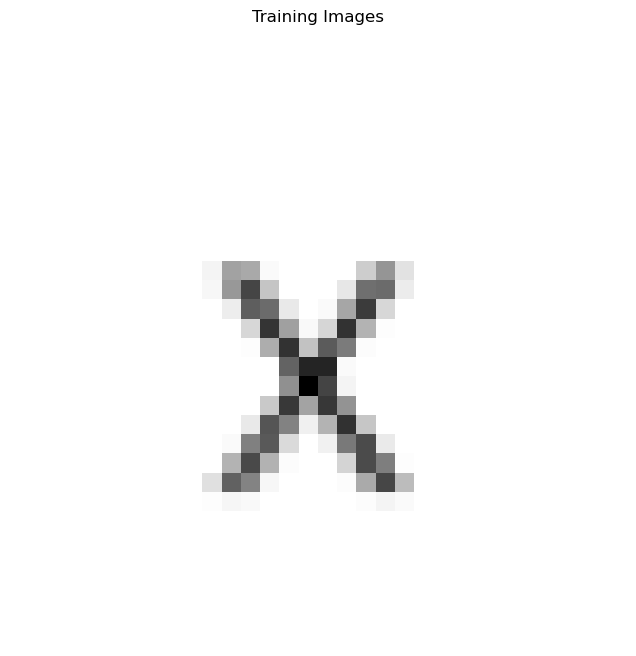

In [17]:

# dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
# device = torch.device("cpu")
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

In [19]:
# CUDA = CUDA and torch.cuda.is_available()
# print("PyTorch version: {}".format(torch.__version__))
# if CUDA:
#     print("CUDA version: {}\n".format(torch.version.cuda))

# if CUDA:
#     torch.cuda.manual_seed(seed)
# device = torch.device("cuda:0" if CUDA else "cpu")
# cudnn.benchmark = True

In [20]:
def weights_init(m):
    #takes class name of m as input
    classname = m.__class__.__name__
    # if its a conv layer initialise weights accordingly
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0,0.02)
    # if its a batchnorm layer initialise weights accordingly    
    elif classname.find('BatchNorm')!= -1:
        nn.init.normal_(m.weight.data, 1.0,0.02)
        #bias terms are set to 0
        nn.init.constant_(m.bias.data,0)

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.label_embedding = nn.Embedding(num_classes, nz)
        self.main = nn.Sequential(

            nn.ConvTranspose2d(nz + ngf*8, ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # 512*4*4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 256*8*8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 128*16*16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 64*32*32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 3*64*64`
        )

    def forward(self, input, labels):
        label_embedding = self.label_embedding(labels).view(labels.size(0), labels.size(1), 1, 1)
        z = torch.cat((label_embedding, input), 1)
        return self.main(z)

In [28]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

Generator(
  (label_embedding): Embedding(26, 100)
  (main): Sequential(
    (0): ConvTranspose2d(612, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1,

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.label_embedding = nn.Embedding(num_classes, nc * 64 * 64) 

        self.main = nn.Sequential(

            nn.Conv2d(nc+ndf, ndf, 4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64*32*32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 128*16*16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 256*8*8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 512*4*4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # Final output is a single integer on which sigmoid is applied
            nn.Sigmoid()
        )

    def forward(self, input, labels):
        label_embedding = self.label_embedding(labels).view(labels.size(0), labels.size(1), 64, 64)
        x = torch.cat((input, label_embedding), 1) 
        return self.main(x)

In [30]:
netD = Discriminator().to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (label_embedding): Embedding(26, 12288)
  (main): Sequential(
    (0): Conv2d(67, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sig

In [32]:
def generate_random_labels(batch_size):
    return torch.randint(0, num_classes, (batch_size,)).to(device)

#we will use binary cross entropy loss for updating the weights and calculating loss
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1,1, device = device)
real_label = 1
fake_label = 0
#update the weights of the discriminator during training
optimizerD = optim.Adam(netD.parameters(), lr=lr , betas=(beta1,0.999))
#update the weights of the generator during training
optimizerG = optim.Adam(netG.parameters(), lr= lr , betas=(beta1,0.999))


In [34]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images, labels, one_hot_labels) in enumerate(dataloader, 0):

        netD.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot encoding to class indices

        one_hot_labels = one_hot_labels.to(device)
        
         
        b_size = images.size(0)
        label_r = torch.full((b_size,), real_label, dtype=torch.float, device=device) 
         
        # Forward pass real batch through D
        output = netD(images, labels).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label_r)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        labels_f = generate_random_labels(b_size)
        # Generate fake image batch with G
        fake = netG(noise,labels_f)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1











Starting Training Loop...


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)